# Analyze Content with Amazon Comprehend and Amazon SageMaker Notebook

The workflow demonstrates how does comprehend work. When the data inputs from social media posts, emails, webpages, documents etc pushed to comprehend, it has the ability to extract Entities, Key Phrases, Language and Sentiment. One could also perform topic modeling on the input data to know various topic clusters it can form. 

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://s3.amazonaws.com/public-ps-datasets/comprehend.png")

Let's start with installing the required packages.

In [1]:
import pandas as pd
from collections import OrderedDict
import requests
from bs4 import BeautifulSoup



Let's connect to comprehend API using boto3.


In [5]:
import boto3
comprehend = boto3.client('comprehend', region_name='us-east-1')

In [98]:
import pandas 
amz_review_path = '/Users/yianc/workspace/recommender/algorithms/amz-review-apparel.csv'
df =  pandas.read_csv(amz_review_path)
product_dict = {} 
traversed = set() 
titles = [] 
idx = 0 
f_name = 'amz_product_title.csv'
output_file = open(f_name, 'w')
for index, row in df.iterrows():
    pid = row['product_id']
    if pid not in traversed: 
        ptitle = row['product_title']
        product_dict[idx] = pid 
        titles.append(ptitle)
        traversed.add(pid)
        output_file.write(str(ptitle)+'\n')
        idx += 1 
output_file.close()         

In [20]:
#create bucket !
def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True


prefix='comprehend'

f_name = 'amz_product_title.csv'
upload_file(f_name, 'sagemaker-iris-yianc', '/'.join([prefix, f_name]))
    

True

In [68]:
import boto3
import json
# from bson import json_util
 
comprehend = boto3.client(service_name='comprehend', region_name='us-east-1')
                
input_s3_url = "s3://sagemaker-iris-yianc/comprehend/amz_product_title.csv"
input_doc_format = "ONE_DOC_PER_LINE"
output_s3_url = "s3://sagemaker-iris-yianc/comprehend-amz-output"
# data_access_role_arn = "arn:aws:iam::230755935769:role/service-role/AmazonSageMaker-ExecutionRole-20200603T105247"
data_access_role_arn = "arn:aws:iam::230755935769:role/TrustComprehendRole"
number_of_topics = 10
 
input_data_config = {"S3Uri": input_s3_url, "InputFormat": input_doc_format}
output_data_config = {"S3Uri": output_s3_url}
 
start_topics_detection_job_result = comprehend.start_topics_detection_job(NumberOfTopics=number_of_topics,
                                                                              InputDataConfig=input_data_config,
                                                                              OutputDataConfig=output_data_config,
                                                                              DataAccessRoleArn=data_access_role_arn)
 
print('start_topics_detection_job_result: ' + json.dumps(start_topics_detection_job_result))
 
job_id = start_topics_detection_job_result["JobId"]
print('job_id: ' + job_id)
# print('describe_topics_detection_job_result: ' + json.dumps(describe_topics_detection_job_result))
#https://docs.aws.amazon.com/cli/latest/reference/iam/create-role.html#:~:text=To%20create%20an%20IAM%20role&text=The%20trust%20policy%20must%20specify,in%20the%20Using%20IAM%20guide.


start_topics_detection_job_result: {"JobId": "3b49ffd0866fcff4343d3faf6a1b9aac", "JobStatus": "SUBMITTED", "ResponseMetadata": {"RequestId": "c92e06ea-2f39-470f-9f9b-aa3f1f40e97e", "HTTPStatusCode": 200, "HTTPHeaders": {"x-amzn-requestid": "c92e06ea-2f39-470f-9f9b-aa3f1f40e97e", "content-type": "application/x-amz-json-1.1", "content-length": "68", "date": "Tue, 11 Aug 2020 03:55:32 GMT"}, "RetryAttempts": 0}}
job_id: 3b49ffd0866fcff4343d3faf6a1b9aac


In [44]:
model_file = None 

while True: 
    describe_topics_detection_job_result = comprehend.describe_topics_detection_job(JobId=job_id)
    print(describe_topics_detection_job_result)
    if describe_topics_detection_job_result['TopicsDetectionJobProperties']['JobStatus'] == 'IN_PROGRESS' or  describe_topics_detection_job_result['TopicsDetectionJobProperties']['JobStatus'] == 'SUBMITTED': 
        time.sleep(10)
    else: 
        if describe_topics_detection_job_result['TopicsDetectionJobProperties']['JobStatus'] == 'COMPLETED': 
            model_file = describe_topics_detection_job_result['TopicsDetectionJobProperties']['OutputDataConfig']['S3Uri']            
        break      

{'TopicsDetectionJobProperties': {'JobId': '4b8e64356411a930690541734f921768', 'JobStatus': 'COMPLETED', 'SubmitTime': datetime.datetime(2020, 8, 11, 8, 31, 19, 420000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2020, 8, 11, 9, 0, 20, 731000, tzinfo=tzlocal()), 'InputDataConfig': {'S3Uri': 's3://sagemaker-iris-yianc/comprehend/amz_product_title.csv', 'InputFormat': 'ONE_DOC_PER_LINE'}, 'OutputDataConfig': {'S3Uri': 's3://sagemaker-iris-yianc/comprehend-amz-output/230755935769-TOPICS-4b8e64356411a930690541734f921768/output/output.tar.gz'}, 'NumberOfTopics': 10, 'DataAccessRoleArn': 'arn:aws:iam::230755935769:role/TrustComprehendRole'}, 'ResponseMetadata': {'RequestId': '8890fc44-0ac6-42ed-aabe-d77ca884cc5e', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '8890fc44-0ac6-42ed-aabe-d77ca884cc5e', 'content-type': 'application/x-amz-json-1.1', 'content-length': '525', 'date': 'Tue, 11 Aug 2020 03:42:32 GMT'}, 'RetryAttempts': 0}}


In [51]:
%%bash -s "$model_file"
echo $1
aws s3 cp "$1" . 
tar -xf output.tar.gz


s3://sagemaker-iris-yianc/comprehend-amz-output/230755935769-TOPICS-4b8e64356411a930690541734f921768/output/output.tar.gz
download: s3://sagemaker-iris-yianc/comprehend-amz-output/230755935769-TOPICS-4b8e64356411a930690541734f921768/output/output.tar.gz to ./output.tar.gz


In [103]:
from collections import defaultdict
import csv
import matplotlib.pyplot as plt
import wordcloud as wc 

def parse_topic_terms(topic_terms_csv):
    topics=defaultdict(dict)
    with open(topic_terms_csv) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                print(f'Column names are {", ".join(row)}')
                line_count += 1
            else:
                topic = row[0]
                term = row[1]
                freq= float(row[2])
                topics[topic][term]=freq
                line_count += 1
        print(f'Processed {line_count} lines.')
    return topics

def plot_topic_word_cloud(topics):      
    plt.figure(figsize=(20,8))

    n_col = 4

    for i, item in enumerate(topics):

        title_str = 'Topic{}'.format(item)

        wordcloud = wc.WordCloud(background_color='white').fit_words(topics[item])

        plt.subplot(len(topics) // n_col+1, n_col, i+1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(title_str)

Column names are topic, term, weight
Processed 101 lines.


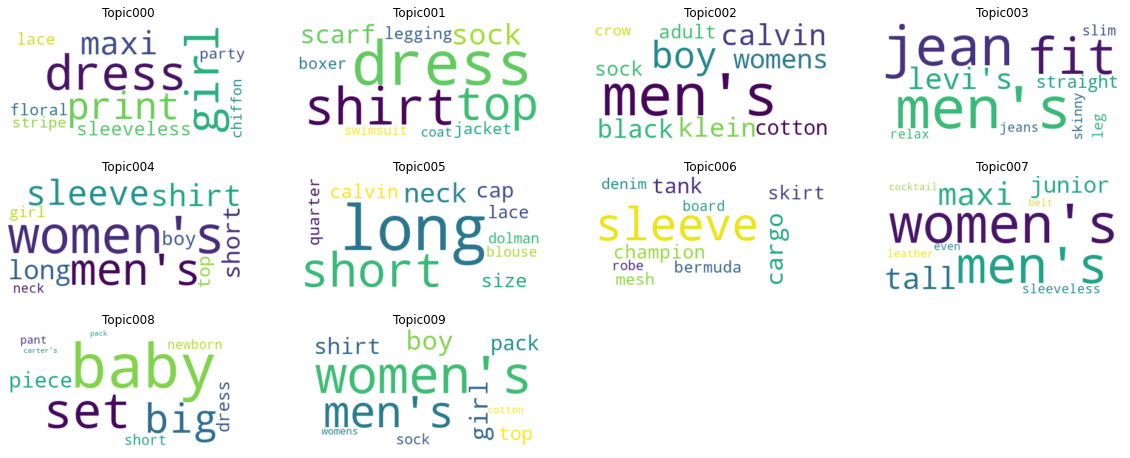

In [104]:
topics = parse_topic_terms('topic-terms.csv')
plot_topic_word_cloud(topics)

Let's extract tweet content and location from each tweet and analyze sentiment of the post.

In [105]:
def remove_heading_zeros(numstr): 
    for i, c in enumerate(numstr):
        if c != '0':
            return numstr[i:]
    return '0'
            

def get_topic_vectors(file, ofile, product_dict): 
    f = open(file, 'r')
    output = open(ofile, 'w')
    lastiidx = -1 
    output.write(str(number_of_topics)+'\n')
    for i, l in enumerate(f.readlines()):
        if i == 0:
            continue
        toks = l.split(',')
        e1 = toks[0]
        iidx = int(e1.split(':')[1])
        iid = product_dict[iidx]
        topic = remove_heading_zeros(toks[1]) 
        e3 = toks[2].strip()
        output.write(iid+","+topic+","+e3+'\n')
    output.close() 

            
            


In [106]:
get_topic_vectors('./doc-topics.csv', 'item-topics.csv', product_dict)

Let's build a dataframe to view the data in tabular form so that the information is easy to consume. 

In [15]:
import pandas as pd
from collections import OrderedDict

result = pd.DataFrame(OrderedDict( {
            'tweets': posts
         , 'location': pd.Series(locations).str.wrap(15)
         , 'timestamp': timestamp
         , 'sentiment': sentiments
         , 'positiveScore': positive
         , 'negativeScore': negative
         , 'neutralScore' : neutral
         }))

In [16]:
result.head()

,tweets,location,timestamp,sentiment,positiveScore,negativeScore,neutralScore
0,How exciting it is to work in a team that hand...,"Cochin, India",2020-08-07 09:27:02,NEUTRAL,0.464122,0.009802,0.526048
1,In love with one of the trainings I have done ...,Spain,2020-08-07 09:19:44,POSITIVE,0.975099,0.000610,0.024290
2,📷 WFH kit delivered to the doorstep #swagitems...,Philippines,2020-08-06 13:27:55,NEUTRAL,0.059044,0.000221,0.940621
3,WFH kit delivered to the doorstep #swagitems #...,Philippines,2020-08-06 13:27:51,NEUTRAL,0.090390,0.000260,0.909341
4,My cutie!! #bepeculiar https://t.co/ny6ygJDOAp,"Seattle, WA",2020-08-06 00:15:52,POSITIVE,0.975721,0.000058,0.024218


We could perform exploratory data analysis on the result dataset to know which location generated more negative        sentiment, which location generated most tweets, does a certain time of the day generates more negative sentiment etc.

In [17]:
print("Locations that generated positive sentiments in the descending order: ")
result.groupby(by='location')['positiveScore'].mean().sort_values(ascending=False)


Locations that generated positive sentiments in the descending order: 


location
Spain                 0.975099
Cochin, India         0.586141
Seattle, WA           0.527855
Arizona, USA          0.504293
Denver, CO            0.099453
Philippines           0.074717
Milano,\nLombardia    0.002412
Texas, USA            0.000113
Name: positiveScore, dtype: float64

In [18]:
result.groupby(by='location', sort = True)['tweets'].count().sort_values(ascending=False)

location
Seattle, WA           5
Cochin, India         3
Philippines           2
Milano,\nLombardia    2
Arizona, USA          2
Texas, USA            1
Spain                 1
Denver, CO            1
Name: tweets, dtype: int64

In [19]:
# Save only the tweets to a dataframe
df = result['tweets']
df.head()

0    How exciting it is to work in a team that hand...
1    In love with one of the trainings I have done ...
2    📷 WFH kit delivered to the doorstep #swagitems...
3    WFH kit delivered to the doorstep #swagitems #...
4       My cutie!! #bepeculiar https://t.co/ny6ygJDOAp
Name: tweets, dtype: object

In [20]:
# Upload the data to S3 

from io import StringIO
import boto3

def write_pd_s3_csv(df, bucket, filepath):
    csv_buffer = StringIO()
    df.to_csv(csv_buffer)
    s3_resource = boto3.resource('s3')
    s3_resource.Object(bucket, filepath).put(Body=csv_buffer.getvalue())
    print("The data is successfully written to S3 path:", bucket+"/"+filepath)

    
s3_bucket =  '' # <your s3 bucket name>
filepath = 'comprehend-blog-example/tweet_data.csv'
write_pd_s3_csv(df, s3_bucket, file_path)

NameError: name 'file_path' is not defined